In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Access and read data into a pandas dataframe
dataset_path = '/content/drive/MyDrive/F_Expr/fer2013.csv'
df = pd.read_csv(dataset_path)

print ('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


In [ ]:
#Keep only relevant data
df = df[df['emotion'].isin([0,3,4,6])]

In [ ]:
#Reset column index to get numbers back from 1-end 
df = df.reset_index(drop=True)

In [ ]:
#Re index classes
df['emotion'].replace({3: 1, 4: 2, 6: 3}, inplace=True)

In [ ]:
#Seperate sets (into new df)
train_set = df[df['Usage'] == 'Training'].copy()
val_set = df[df['Usage'] == 'PublicTest'].copy()
test_set = df[df['Usage'] == 'PrivateTest'].copy()

In [ ]:
#Function to split and form/shape data 
def prepare_data(data_set):
  new_img = []
  images = list(data_set['pixels'])
 
  for image in images:
    image = image.split()
    new_img.append(image)
  
  new_img = np.array(new_img)
  new_img = new_img.reshape(data_set.shape[0], 48, 48, 1)
  new_img = new_img.astype('float32')/255
  #new_img = tf.image.resize(new_img, (120, 120))

  labels = to_categorical(data_set['emotion'], 4)
  

  return new_img, labels

In [ ]:
#Prepare sets for passing into the model via prepare_data function 
X_train, y_train = prepare_data(train_set)
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

In [ ]:
#Create and Instantiate model
def my_model():
  input_shape = (48, 48, 1)
    # Create and compile model
  model = models.Sequential()
  model.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64,(3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv2D(128,(3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128,(3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv2D(256,(3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(256,(3,3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.5))



  model.add(layers.Flatten())
  model.add(layers.Dense(128,activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4,activation='softmax'))
   
    
  return model

In [ ]:
model = my_model()
opt = optimizers.RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Use data augmentation
train_datagen = ImageDataGenerator( 
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
    )

In [ ]:
earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.1,
    patience=20,
    mode="max",
    baseline=None,
    restore_best_weights=False,
)

lrplat = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    mode="max",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00001,
)

In [ ]:
#Train the model
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size= 64),
    steps_per_epoch = len(X_train) // 64,
    epochs=100,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[lrplat]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
328/328 [==============================] - 20s 35ms/step - loss: 2.1849 - accuracy: 0.2815 - val_loss: 4.1901 - val_accuracy: 0.1922
Epoch 2/100
328/328 [==============================] - 11s 34ms/step - loss: 1.6112 - accuracy: 0.2802 - val_loss: 1.5306 - val_accuracy: 0.2490
Epoch 3/100
328/328 [==============================] - 11s 34ms/step - loss: 1.6159 - accuracy: 0.2809 - val_loss: 3.5610 - val_accuracy: 0.3413
Epoch 4/100
328/328 [==============================] - 11s 34ms/step - loss: 1.5814 - accuracy: 0.2894 - val_loss: 2.9788 - val_accuracy: 0.3436
Epoch 5/100
328/328 [==============================] - 11s 34ms/step - loss: 1.6114 - accuracy: 0.2946 - val_loss: 2.3165 - val_accuracy: 0.1781
Epoch 6/100
328/328 [==============================] - 11s 34ms/step - loss: 1.6065 - accuracy: 0.2883 - val_loss: 2.1230 - val_accuracy: 0.3402
Epoch 7/100
328/328 [==============================] - 11s 34ms/step - loss: 1.6627 - accuracy: 0.2839 - val_loss: 1.4022 - val_ac

In [ ]:
#Evaluate model to never seen data
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

21/21 [==============================] - 1s 14ms/step - loss: 0.6746 - accuracy: 0.7212
test loss, test acc: [0.6745578050613403, 0.7212355136871338]


In [ ]:
#Save model's weights
model.save('/content/drive/My Drive/model.h5')

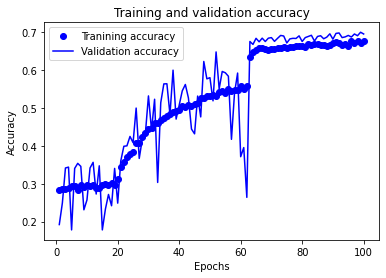

In [ ]:
#Plot accuracy
def plot_acc():
    
    plt.clf()

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']


    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, 'bo', label='Tranining accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
plot_acc()

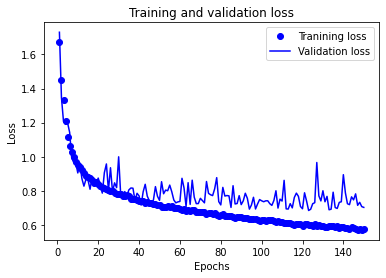

In [ ]:
#Plot loss
def plot_loss():
    
    plt.clf()
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Tranining loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_loss()